## Example BS100BW

In [1]:
# %% set gpu usage
from usbmd.tensorflow_ultrasound.utils.gpu_config import set_gpu_usage
set_gpu_usage(device='auto:1') #device = 5

     memory
GPU        
0       501
1     17787
2       881
3      4740
4      9751
5      3110
6     14171
7       473
Selecting 1 GPUs based on available memory.
Selected GPU 1 with Free Memory: 17787.00 MiB


[1]

In [2]:
# %% load config
from pathlib import Path
from usbmd.utils.config import load_config_from_yaml
from usbmd.utils.config_validation import check_config
import os

# Load the config file
#config_path = Path.cwd() / 'configs/config_usbmd_dataset.yaml'
config_path = Path("D:\Beatrice_Federici\BMd_Ultrasound_Toolbox\configs\config_usbmd_rf.yaml")
#config_path = Path('configs', 'config_usbmd_rf.yaml')
config = load_config_from_yaml(config_path)
#config.scan.n_angles = [0] #list(range(128,128+5))

# Check the config file for errors
config = check_config(config)


In [8]:
# %% load dataset
from usbmd.data_format.usbmd_data_format import load_usbmd_file
import numpy as np

folder_path = config.data.dataset_folder
file_path = config.data.file_path
data_path = folder_path + '\\' + file_path
#data_path = r"Z:\Ultrasound-BMd\data\USBMD-example-data\planewave_l115v.hdf5"
# Load the data file and construct a probe and scan object
# We will only load the first two frames of the data file
data, scan, probe = load_usbmd_file(data_path, frames=[0], transmits = [3])


In [9]:
print(data.shape)
print(scan.Nx)
print(scan.Nz)
print(scan.n_ch)
print(scan.n_ax)
print(scan.n_tx)
print(scan.angles)
print(scan.modtype)
print(scan.initial_times)
print(scan.fdemod)
print(scan.fs)
print(scan.fc)
print(scan.bandwidth_percent)
print(probe.ele_pos.max())

print(config.data.modtype)

scan.Nz = 500
scan.Nx = 500
scan.initial_times = [np.abs(np.sin(np.deg2rad(np.linspace(-18, 18, 7)[3])))*probe.ele_pos.max()/scan.c]
#scan.initial_times = np.abs(np.sin(np.deg2rad(np.linspace(-18, 18, 7))))*probe.ele_pos.max()/scan.c



print(scan.initial_times)
print(scan.fdemod)
print(scan.fs)
print(scan.fc)
print(probe.ele_pos)


(1, 1, 128, 576, 2)
128
128
2
576
1
[0.]
iq
[6.4e-07]
7812500.0
7812500.0
7812500.0
100.0
0.01853184
None
[0.0]
7812500.0
7812500.0
7812500.0
[[-0.01853184  0.          0.        ]
 [-0.01824     0.          0.        ]
 [-0.01794816  0.          0.        ]
 [-0.01765632  0.          0.        ]
 [-0.01736448  0.          0.        ]
 [-0.01707264  0.          0.        ]
 [-0.0167808   0.          0.        ]
 [-0.01648896  0.          0.        ]
 [-0.01619712  0.          0.        ]
 [-0.01590528  0.          0.        ]
 [-0.01561344  0.          0.        ]
 [-0.0153216   0.          0.        ]
 [-0.01502976  0.          0.        ]
 [-0.01473792  0.          0.        ]
 [-0.01444608  0.          0.        ]
 [-0.01415424  0.          0.        ]
 [-0.0138624   0.          0.        ]
 [-0.01357056  0.          0.        ]
 [-0.01327872  0.          0.        ]
 [-0.01298688  0.          0.        ]
 [-0.01269504  0.          0.        ]
 [-0.0124032   0.          0.        ]


Text(0, 0.5, 'z [mm]')

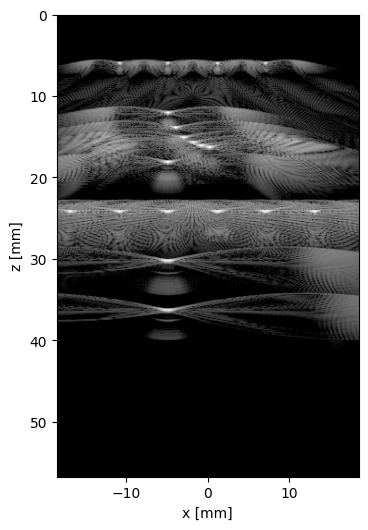

In [10]:
# %% beamforming RF data
from usbmd.tensorflow_ultrasound.layers.beamformers import get_beamformer
import tensorflow as tf
from usbmd.processing import rf2iq, log_compress
import matplotlib.pyplot as plt

# beamformer
beamformer = get_beamformer(probe=probe, scan=scan, config=config)
# beamform the data
beamformed_data = beamformer(data)[0]
# envelope
image = np.linalg.norm(beamformed_data, axis=-1)
# normalize
image = image / tf.reduce_max(image)
# log compression
image = 20 * tf.math.log(image) / tf.math.log(10.0)
# remove nan and inf
image = tf.where(tf.math.is_nan(image), config.data.dynamic_range[0], image)
image = tf.where(tf.math.is_inf(image), config.data.dynamic_range[0], image)
image = tf.clip_by_value(image, config.data.dynamic_range[0], 0)
# Plot the image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(image,
          cmap='gray',
          extent=[scan.xlims[0]*1000, scan.xlims[1]*1000, scan.zlims[1]*1000, scan.zlims[0]*1000],
          vmin=config.data.dynamic_range[0],
          vmax=config.data.dynamic_range[1])
#ax.set_aspect('auto', adjustable='box')
# Add labels
ax.set_xlabel('x [mm]')
ax.set_ylabel('z [mm]')






In [6]:
attrs = vars(scan)
print(', '.join("%s: %s" % item for item in attrs.items()))

n_tx: 7, fc: 7812500.0, fs: 7812500.0, bandwidth_percent: 100.0, c: 1540.0, modtype: iq, n_ax: 576, fdemod: 7812500.0, n_ch: 2, wvln: 0.00019712, pixels_per_wavelength: 3, _xlims: (-0.01853184, 0.01853184), _ylims: (0, 0), _zlims: (0, 0.05677056), _Nx: 500, _Nz: 500, _grid: [[[-0.01853184 -0.          0.        ]
  [-0.01845756 -0.          0.        ]
  [-0.01838329 -0.          0.        ]
  ...
  [ 0.01838329  0.          0.        ]
  [ 0.01845756  0.          0.        ]
  [ 0.01853184  0.          0.        ]]

 [[-0.01853184 -0.          0.00011377]
  [-0.01845756 -0.          0.00011377]
  [-0.01838329 -0.          0.00011377]
  ...
  [ 0.01838329  0.          0.00011377]
  [ 0.01845756  0.          0.00011377]
  [ 0.01853184  0.          0.00011377]]

 [[-0.01853184 -0.          0.00022754]
  [-0.01845756 -0.          0.00022754]
  [-0.01838329 -0.          0.00022754]
  ...
  [ 0.01838329  0.          0.00022754]
  [ 0.01845756  0.          0.00022754]
  [ 0.01853184  0.     